In [1]:
import os
import tarfile
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, RandomCrop, ToTensor, Resize, ToPILImage

In [2]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['bmp', '.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])

class DatasetFromfolder(Dataset):
    def __init__(self, path):
        super(DatasetFromfolder, self).__init__()
        self.filenames = []
        folders = os.listdir(path)
        for f in folders:
            self.filenames.append(path + f)
        self.data_transform = Compose([RandomCrop([33, 33]), ToTensor()])
        self.data_transform_PIL = Compose([ToPILImage()])

    def __getitem__(self, index):        
        w = h = 512
        img = Image.open(self.filenames[index])
        img, _cb, _cr = img.convert('YCbCr').split()     
        img = self.data_transform(img)           
        result_image = img
        
        resize_image = self.data_transform_PIL(img)        
        resize_image = resize_image.resize((int(w/4), int(h/4)))
        resize_image = resize_image.resize((w, h), Image.BICUBIC)
        resize_image = self.data_transform(resize_image) 
        
        return result_image, resize_image

    def __len__(self):
        return len(self.filenames)

In [3]:
root_dir = '../input/xray-normal/xray_dataset_normal/'

In [15]:
test_path_normal = os.path.join(root_dir, "test/NORMAL")

test_img_normal_paths = sorted(
    [
        os.path.join(test_path_normal, fname)
        for fname in os.listdir(test_path_normal)
        if fname.endswith(".jpeg")
    ]
)

In [4]:
test_path_pneumonia = os.path.join(root_dir, "test/PNEUMONIA")

test_img_pneumonia_paths = sorted(
    [
        os.path.join(test_path_pneumonia, fname)
        for fname in os.listdir(test_path_pneumonia)
        if fname.endswith(".jpeg")
    ]
)

In [5]:
class SuperResolutionCNN(nn.Module):
    def __init__(self):
        super(SuperResolutionCNN, self).__init__()
        self.Conv1 = nn.Conv2d(1, 64, 9, 1, 4)
        self.Conv2 = nn.Conv2d(64, 32, 3, 1, 1)
        self.Conv3 = nn.Conv2d(32, 1, 5, 1, 2)
        self.Relu = nn.ReLU()
        self.sig = nn.Sigmoid()

    def forward(self, x):
        out = self.Relu(self.Conv1(x))
        out = self.Relu(self.Conv2(out))
        out = self.Conv3(out)
        return out

In [6]:
data_transform = Compose([ToTensor()])    
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_set = DatasetFromfolder('../input/xray-normal/xray_dataset_normal/train/')
train_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=64, shuffle=True)

SRCNN = SuperResolutionCNN()
if torch.cuda.device_count() > 1:
    SRCNN = nn.DataParallel(SRCNN)
SRCNN.to(device)    

optimizer = optim.Adam(SRCNN.parameters())
criterion = nn.MSELoss().to(device)

new_point = 0
os.system('mkdir /tmp/checkpoint')
os.system('mkdir /tmp/image')

0

In [7]:
def train(NUM_EPOCHS=1):
    #NUM_EPOCHS = 10 #501
#     data_transform = Compose([ToTensor()])    
    
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     train_set = DatasetFromfolder('../input/xray-normal/xray_dataset_normal/train/')
#     train_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=64, shuffle=True)
    
#     SRCNN = SuperResolutionCNN()
#     if torch.cuda.device_count() > 1:
#         SRCNN = nn.DataParallel(SRCNN)
#     SRCNN.to(device)    
    
#     optimizer = optim.Adam(SRCNN.parameters())
#     criterion = nn.MSELoss().to(device)
    
    new_point = 0
#     os.system('mkdir checkpoint')
#     os.system('mkdir image')
    
    for epoch in range(NUM_EPOCHS+1):        
        batch_idx = 0        
        for HR, LR in train_loader:
            HR = HR.to(device)
            LR = LR.to(device)            
            newHR = SRCNN(LR) 
            
            SRCNN.train()
            SRCNN.zero_grad()
            loss = criterion(HR, newHR)
            loss.backward(retain_graph=True)
            optimizer.step()
            
            if epoch%25==0 and batch_idx%1==0:
                SRCNN.eval()
                print("Epoch:{} batch[{}/{}] loss:{}".format(epoch, batch_idx, len(train_loader), loss))      
                
                img = Image.open('../input/xray-normal/xray_dataset_normal/test/PNEUMONIA/person100_bacteria_479.jpeg')   
                            
                w, h = img.size
                
                result_image = img
                result_image_y, _cb, _cr = result_image.convert('YCbCr').split()
                result_image_y = data_transform(result_image_y)   
        
                resize_image = img.resize((int(w/3), int(h/3)), Image.BICUBIC)       
                resize_image = resize_image.resize((w, h), Image.BICUBIC)
                resize_image_y, _cb, _cr = resize_image.convert('YCbCr').split()
                resize_image_y = data_transform(resize_image_y).to(device)
                newHR = SRCNN(resize_image_y.unsqueeze(0))
                
                torchvision.utils.save_image(resize_image_y, f'/tmp/image/LR{epoch}.png')
                torchvision.utils.save_image(result_image_y, f'/tmp/image/HR{epoch}.png')
                torchvision.utils.save_image(newHR, f'/tmp/image/newHR{epoch}.png')
                
                im1 = Image.open(f'/tmp/image/LR{epoch}.png')
                im2 = Image.open(f'/tmp/image/HR{epoch}.png')
                im3 = Image.open(f'/tmp/image/newHR{epoch}.png')                
                dst = Image.new('RGB', (w*3 , h))
                dst.paste(im1, (0, 0))
                dst.paste(im2, (w, 0))
                dst.paste(im3, (w*2, 0))
                dst.save(f'/tmp/image/image{epoch}.png')
                img = Image.open(f'/tmp/image/image{epoch}.png')
                plt.imshow(img)
                plt.title(f'Image After {epoch} epochs')
                plt.show()
                
            batch_idx += 1
            
        torch.save(SRCNN.state_dict(), '/tmp/checkpoint/ckpt_%d.pth' % (new_point))
        new_point += 1

Epoch:0 batch[0/21] loss:0.26290491223335266


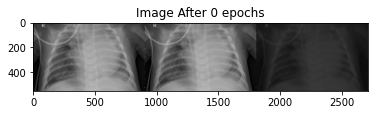

Epoch:0 batch[1/21] loss:0.17529363930225372


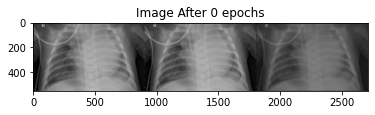

Epoch:0 batch[2/21] loss:0.05222773924469948


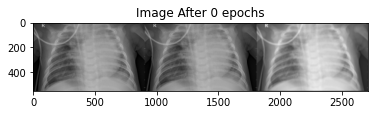

Epoch:0 batch[3/21] loss:0.033325228840112686


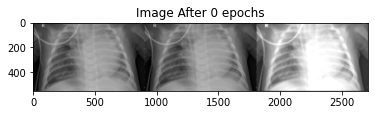

Epoch:0 batch[4/21] loss:0.0840882733464241


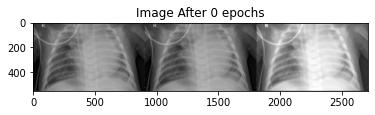

Epoch:0 batch[5/21] loss:0.04834635555744171


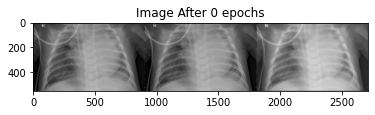

Epoch:0 batch[6/21] loss:0.028991857543587685


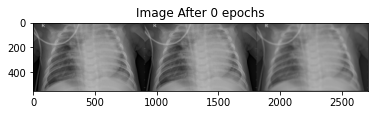

Epoch:0 batch[7/21] loss:0.01964864693582058


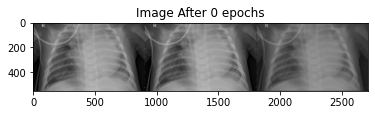

Epoch:0 batch[8/21] loss:0.026856765151023865


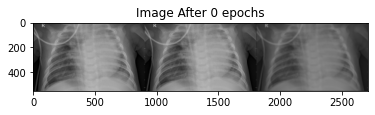

Epoch:0 batch[9/21] loss:0.042138099670410156


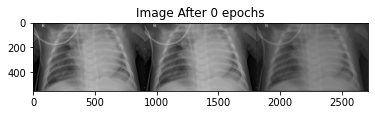

Epoch:0 batch[10/21] loss:0.03419124707579613


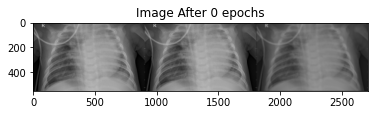

Epoch:0 batch[11/21] loss:0.03405693545937538


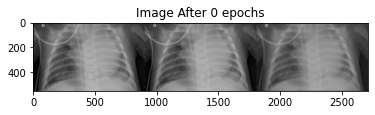

Epoch:0 batch[12/21] loss:0.02862408757209778


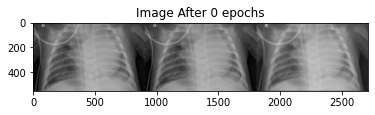

Epoch:0 batch[13/21] loss:0.014710712246596813


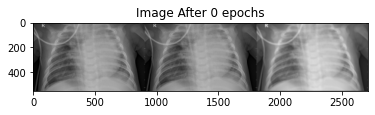

Epoch:0 batch[14/21] loss:0.029676228761672974


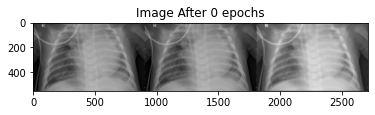

Epoch:0 batch[15/21] loss:0.022575505077838898


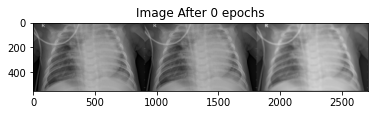

Epoch:0 batch[16/21] loss:0.02053936943411827


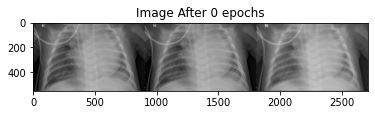

Epoch:0 batch[17/21] loss:0.01400771364569664


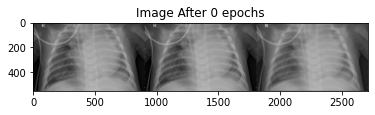

Epoch:0 batch[18/21] loss:0.010952268727123737


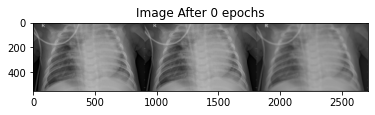

Epoch:0 batch[19/21] loss:0.02102472074329853


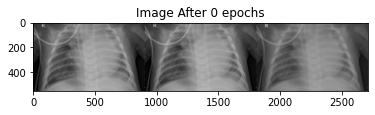

Epoch:0 batch[20/21] loss:0.012490454129874706


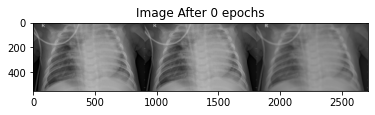

Epoch:25 batch[0/21] loss:0.00504263723269105


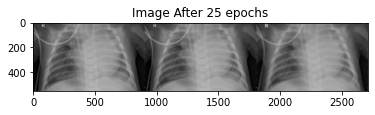

Epoch:25 batch[1/21] loss:0.005250212736427784


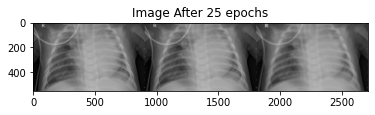

Epoch:25 batch[2/21] loss:0.005633731372654438


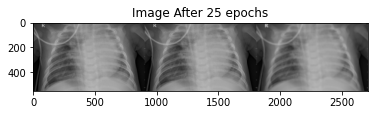

Epoch:25 batch[3/21] loss:0.0063826218247413635


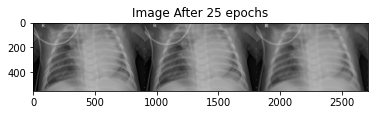

Epoch:25 batch[4/21] loss:0.0046038334257900715


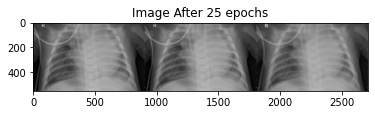

Epoch:25 batch[5/21] loss:0.004718974698334932


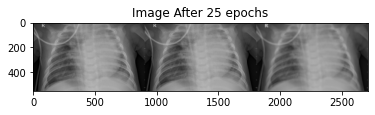

Epoch:25 batch[6/21] loss:0.004525828640908003


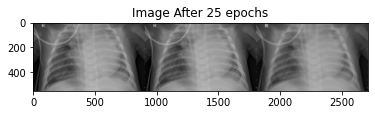

Epoch:25 batch[7/21] loss:0.0037041243631392717


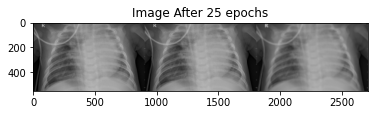

Epoch:25 batch[8/21] loss:0.005567133892327547


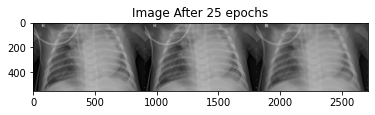

Epoch:25 batch[9/21] loss:0.004215267486870289


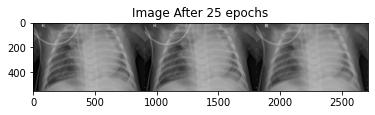

Epoch:25 batch[10/21] loss:0.006974981166422367


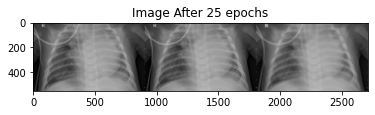

Epoch:25 batch[11/21] loss:0.005083764903247356


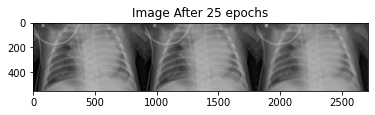

Epoch:25 batch[12/21] loss:0.005674037151038647


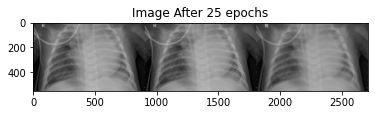

Epoch:25 batch[13/21] loss:0.005539226345717907


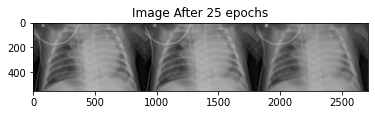

Epoch:25 batch[14/21] loss:0.002996520372107625


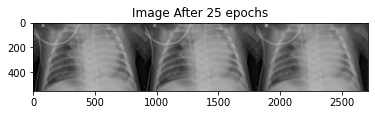

Epoch:25 batch[15/21] loss:0.0053962524980306625


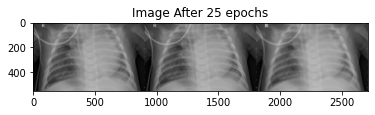

Epoch:25 batch[16/21] loss:0.005467209033668041


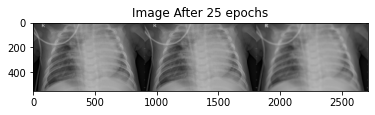

Epoch:25 batch[17/21] loss:0.004279620014131069


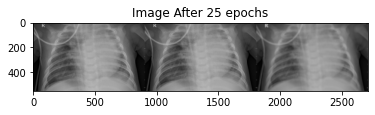

Epoch:25 batch[18/21] loss:0.003614658024162054


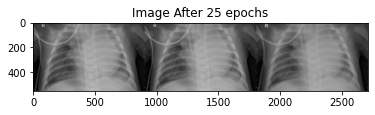

Epoch:25 batch[19/21] loss:0.0044794525019824505


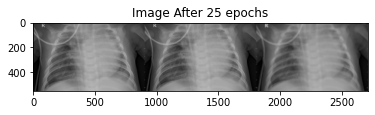

Epoch:25 batch[20/21] loss:0.00351241254247725


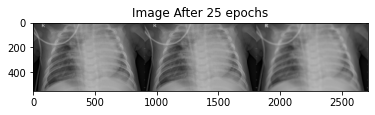

Epoch:50 batch[0/21] loss:0.0046619451604783535


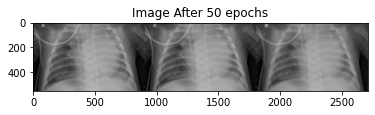

Epoch:50 batch[1/21] loss:0.0041961511597037315


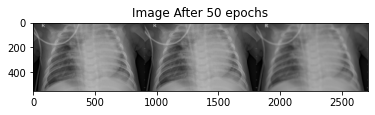

Epoch:50 batch[2/21] loss:0.005854152143001556


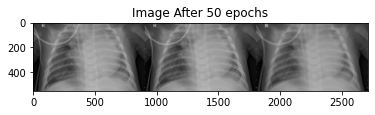

Epoch:50 batch[3/21] loss:0.004517697729170322


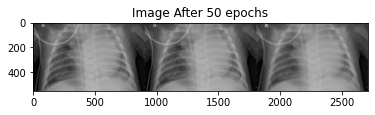

Epoch:50 batch[4/21] loss:0.005396662279963493


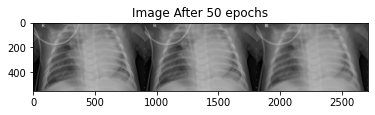

Epoch:50 batch[5/21] loss:0.0029757514130324125


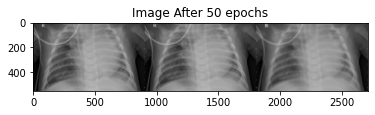

Epoch:50 batch[6/21] loss:0.004125581588596106


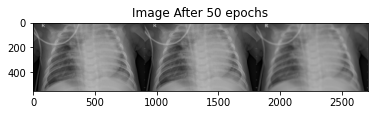

Epoch:50 batch[7/21] loss:0.007042088080197573


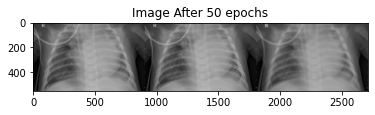

Epoch:50 batch[8/21] loss:0.003794747171923518


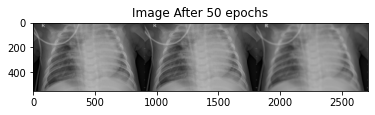

Epoch:50 batch[9/21] loss:0.008431628346443176


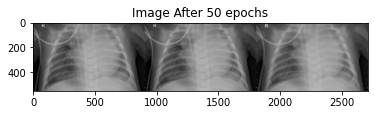

Epoch:50 batch[10/21] loss:0.005130616948008537


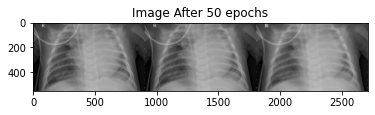

Epoch:50 batch[11/21] loss:0.007043276913464069


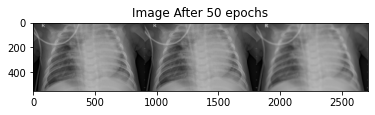

Epoch:50 batch[12/21] loss:0.020390786230564117


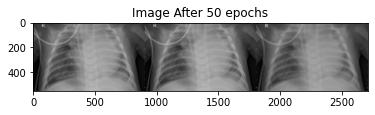

Epoch:50 batch[13/21] loss:0.005337593145668507


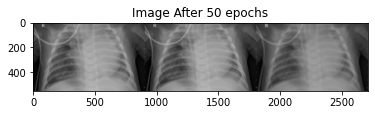

Epoch:50 batch[14/21] loss:0.005716016981750727


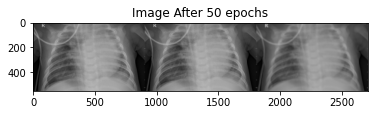

Epoch:50 batch[15/21] loss:0.006410855799913406


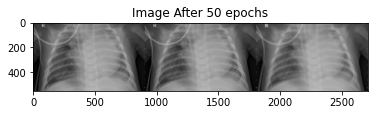

Epoch:50 batch[16/21] loss:0.004861149936914444


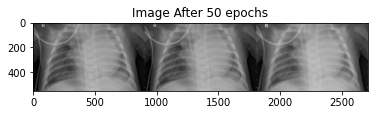

Epoch:50 batch[17/21] loss:0.00585797568783164


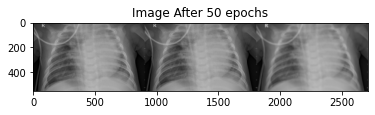

Epoch:50 batch[18/21] loss:0.005469346884638071


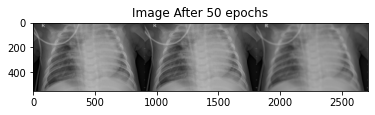

Epoch:50 batch[19/21] loss:0.005439906846731901


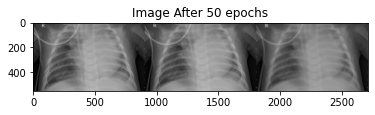

Epoch:50 batch[20/21] loss:0.008046513423323631


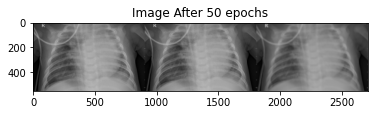

Epoch:75 batch[0/21] loss:0.005559660494327545


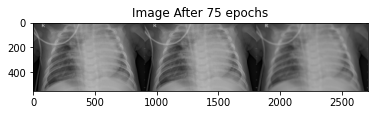

Epoch:75 batch[1/21] loss:0.00447041355073452


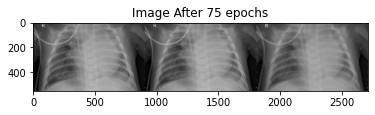

Epoch:75 batch[2/21] loss:0.0053225369192659855


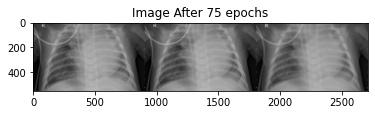

Epoch:75 batch[3/21] loss:0.005734623875468969


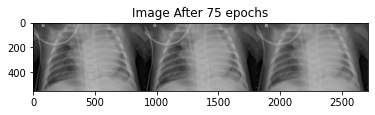

Epoch:75 batch[4/21] loss:0.0064333039335906506


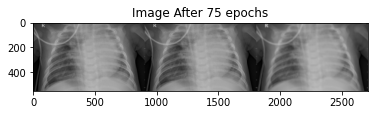

Epoch:75 batch[5/21] loss:0.00659978250041604


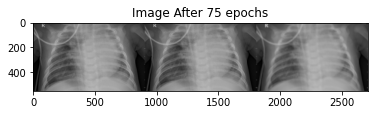

Epoch:75 batch[6/21] loss:0.004203696735203266


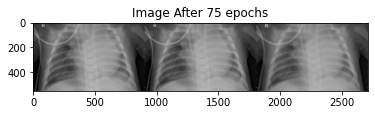

Epoch:75 batch[7/21] loss:0.004973955452442169


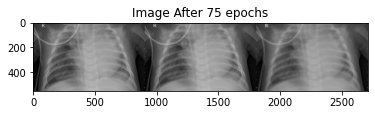

Epoch:75 batch[8/21] loss:0.003803596831858158


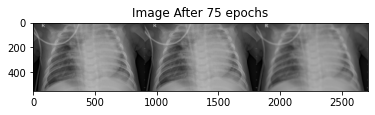

Epoch:75 batch[9/21] loss:0.004916797857731581


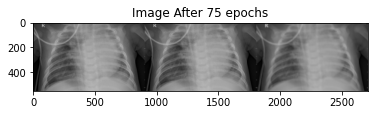

Epoch:75 batch[10/21] loss:0.004667960572987795


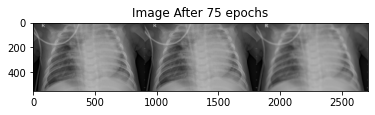

Epoch:75 batch[11/21] loss:0.0058097331784665585


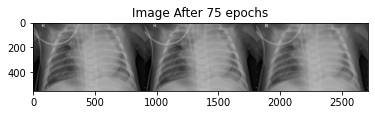

Epoch:75 batch[12/21] loss:0.008729790337383747


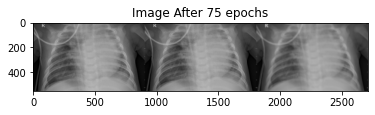

Epoch:75 batch[13/21] loss:0.005141664296388626


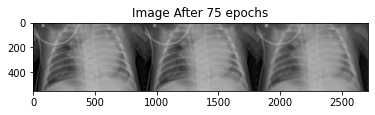

Epoch:75 batch[14/21] loss:0.004389134701341391


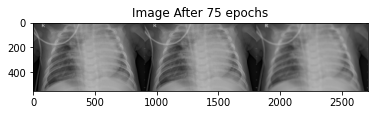

Epoch:75 batch[15/21] loss:0.005740198772400618


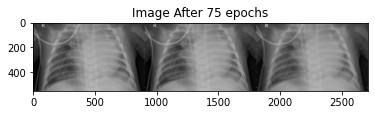

Epoch:75 batch[16/21] loss:0.004324101842939854


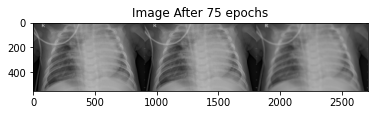

Epoch:75 batch[17/21] loss:0.005196178797632456


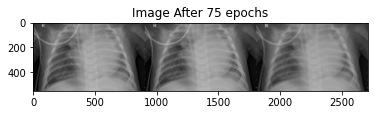

Epoch:75 batch[18/21] loss:0.0055245463736355305


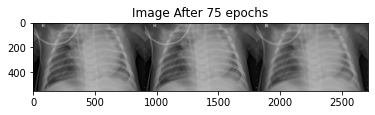

Epoch:75 batch[19/21] loss:0.0047195241786539555


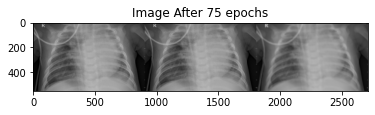

Epoch:75 batch[20/21] loss:0.005685976706445217


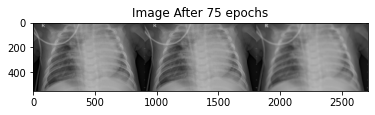

Epoch:100 batch[0/21] loss:0.013807125389575958


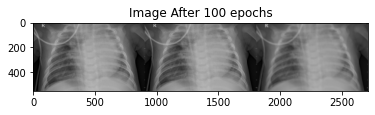

Epoch:100 batch[1/21] loss:0.004217004403471947


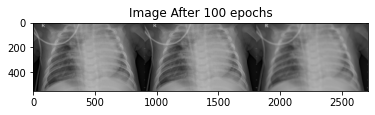

Epoch:100 batch[2/21] loss:0.0033617790322750807


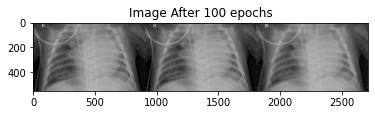

Epoch:100 batch[3/21] loss:0.002885823603719473


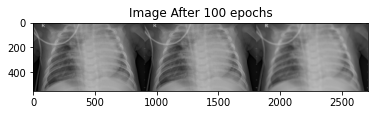

Epoch:100 batch[4/21] loss:0.004797983914613724


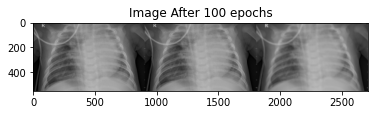

Epoch:100 batch[5/21] loss:0.00473577668890357


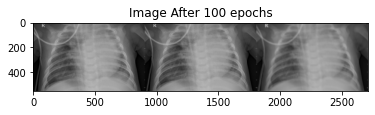

Epoch:100 batch[6/21] loss:0.0049924589693546295


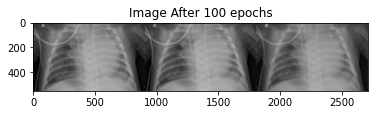

Epoch:100 batch[7/21] loss:0.005739267915487289


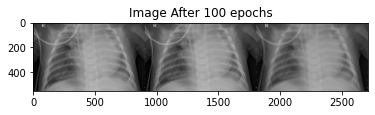

Epoch:100 batch[8/21] loss:0.006366745103150606


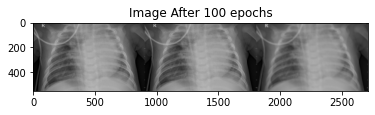

Epoch:100 batch[9/21] loss:0.005284759681671858


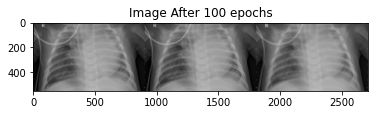

Epoch:100 batch[10/21] loss:0.0063928766176104546


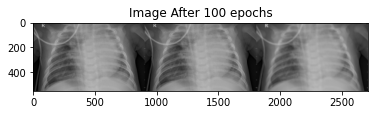

Epoch:100 batch[11/21] loss:0.0032392488792538643


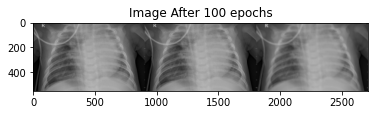

Epoch:100 batch[12/21] loss:0.0041307853534817696


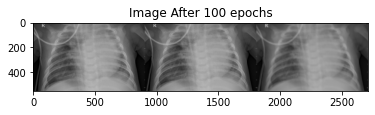

Epoch:100 batch[13/21] loss:0.005530932452529669


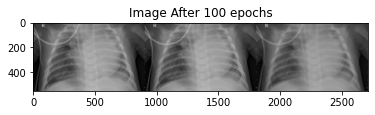

Epoch:100 batch[14/21] loss:0.004687406588345766


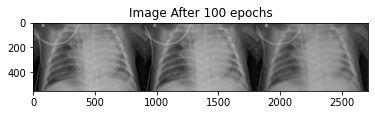

Epoch:100 batch[15/21] loss:0.0044400678016245365


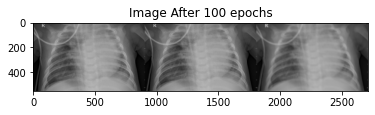

Epoch:100 batch[16/21] loss:0.0033892786595970392


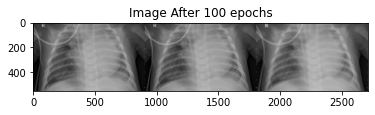

Epoch:100 batch[17/21] loss:0.005942351184785366


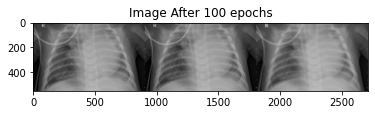

Epoch:100 batch[18/21] loss:0.005223173648118973


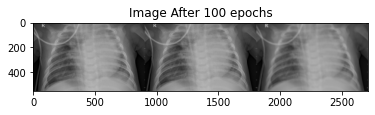

Epoch:100 batch[19/21] loss:0.00414521899074316


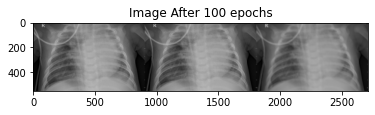

Epoch:100 batch[20/21] loss:0.004658074118196964


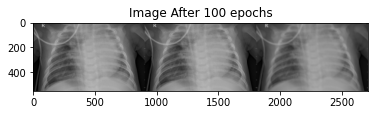

In [8]:
n_epochs=100
train(NUM_EPOCHS=n_epochs)

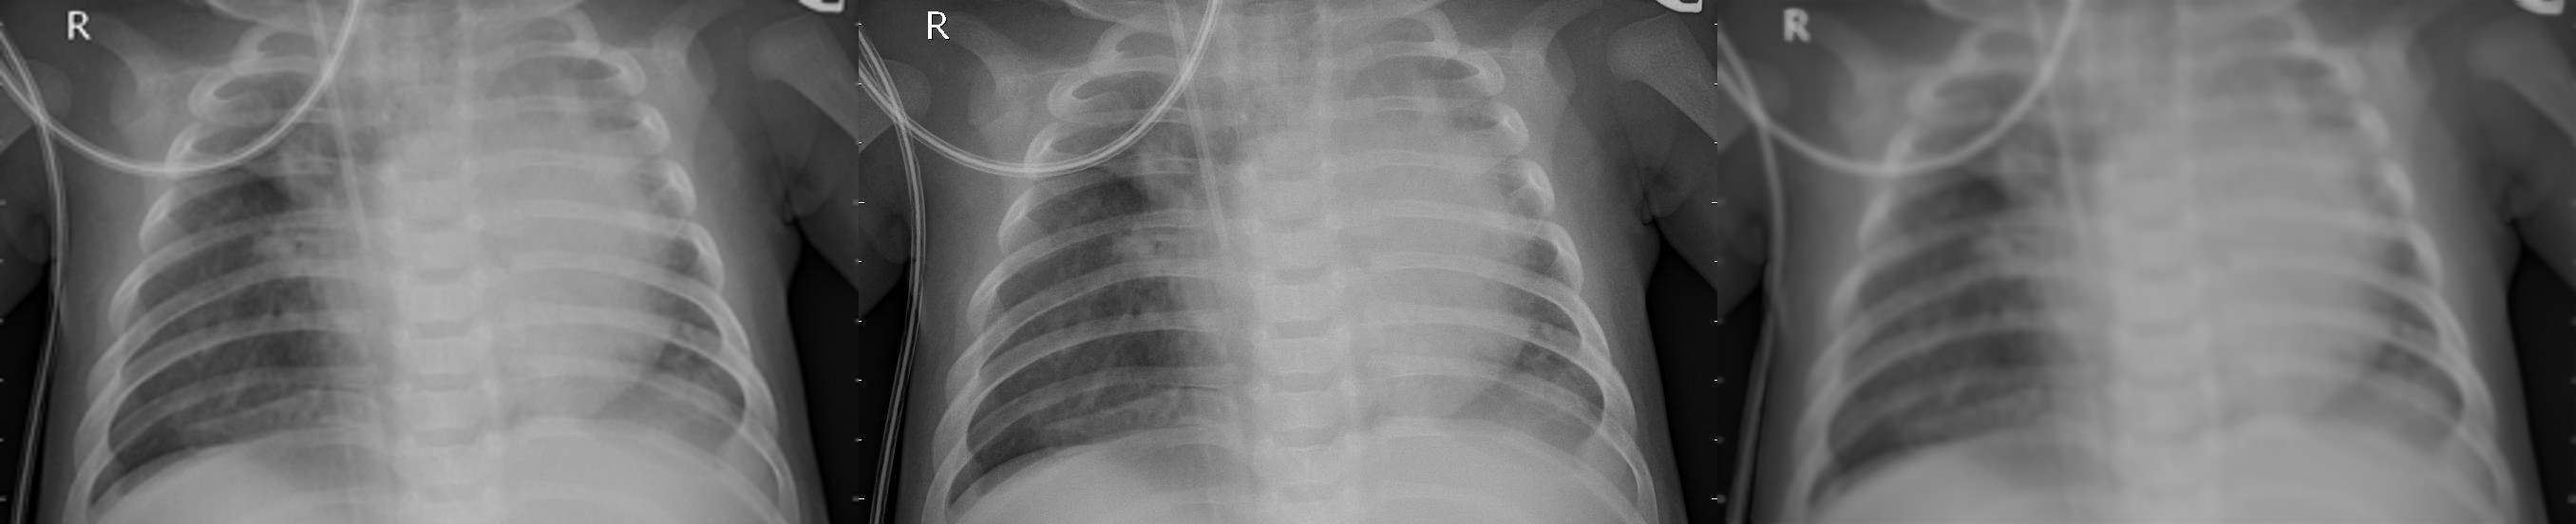

In [9]:
Image.open(f'/tmp/image/image{n_epochs}.png')

In [10]:
# from IPython.display import FileLink
#FileLink('./image/image.png')
#FileLink('./image/LR.png')
#FileLink('./image/HR.png')
#FileLink('./image/newHR.png')

In [11]:
os.system('mkdir /tmp/HR_PNEUMONIA_imgs')
os.system('mkdir /tmp/SR_PNEUMONIA_imgs')

0

In [16]:
os.system('mkdir /tmp/HR_NORMAL_imgs')
os.system('mkdir /tmp/SR_NORMAL_imgs')

0

In [17]:
# total_bicubic_psnr = 0.0
# total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_normal_paths[:]):
    #print("Epoch:{} batch[{}/{}] loss:{}".format(epoch+1, batch_idx+1, len(train_loader), loss))    
    
    data_transform = Compose([ToTensor()])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    img = Image.open(test_img_path)   

    w, h = img.size

    result_image = img
    result_image_y, _cb, _cr = result_image.convert('YCbCr').split()
    result_image_y = data_transform(result_image_y)   

    resize_image = img.resize((int(w/3), int(h/3)), Image.BICUBIC)       
    resize_image = resize_image.resize((w, h), Image.BICUBIC)
    resize_image_y, _cb, _cr = resize_image.convert('YCbCr').split()
    resize_image_y = data_transform(resize_image_y).to(device)
    newHR = SRCNN(resize_image_y.unsqueeze(0))
    
#     plot_results(resize_image_y, index, "lowres")
#     plot_results(result_image_y, index, "highres")
#     plot_results(newHR, index, "prediction")

#     torchvision.utils.save_image(resize_image_y, f'./output/LR{index+1}.png')
    torchvision.utils.save_image(result_image_y, f'/tmp/HR_NORMAL_imgs/HR{index+1}.png')
    torchvision.utils.save_image(newHR, f'/tmp/SR_NORMAL_imgs/newHR{index+1}.png')

#     im1 = Image.open(f'./output/LR{index+1}.png')
#     im2 = Image.open(f'./output/HR{index+1}.png')
#     im3 = Image.open(f'./output/newHR{index+1}.png')                
#     dst = Image.new('RGB', (w*3 , h))
#     dst.paste(im1, (0, 0))
#     dst.paste(im2, (w, 0))
#     dst.paste(im3, (w*2, 0))
    
#     dst.save(f'./output/image{index+1}.png')
#     img = Image.open(f'./output/image{index+1}.png')
#     plt.imshow(img)
#     plt.title(f'Test Image {index+1}')
#     plt.show()

In [18]:
%%!

zip -r HR_NORMAL_imgs.zip /tmp/HR_NORMAL_imgs

['  adding: tmp/HR_NORMAL_imgs/ (stored 0%)',
 '  adding: tmp/HR_NORMAL_imgs/HR118.png (deflated 0%)',
 '  adding: tmp/HR_NORMAL_imgs/HR186.png (deflated 0%)',
 '  adding: tmp/HR_NORMAL_imgs/HR208.png (deflated 0%)',
 '  adding: tmp/HR_NORMAL_imgs/HR171.png (deflated 0%)',
 '  adding: tmp/HR_NORMAL_imgs/HR146.png (deflated 0%)',
 '  adding: tmp/HR_NORMAL_imgs/HR25.png (deflated 0%)',
 '  adding: tmp/HR_NORMAL_imgs/HR48.png (deflated 0%)',
 '  adding: tmp/HR_NORMAL_imgs/HR43.png (deflated 0%)',
 '  adding: tmp/HR_NORMAL_imgs/HR218.png (deflated 0%)',
 '  adding: tmp/HR_NORMAL_imgs/HR101.png (deflated 0%)',
 '  adding: tmp/HR_NORMAL_imgs/HR177.png (deflated 0%)',
 '  adding: tmp/HR_NORMAL_imgs/HR125.png (deflated 0%)',
 '  adding: tmp/HR_NORMAL_imgs/HR58.png (deflated 0%)',
 '  adding: tmp/HR_NORMAL_imgs/HR209.png (deflated 0%)',
 '  adding: tmp/HR_NORMAL_imgs/HR142.png (deflated 0%)',
 '  adding: tmp/HR_NORMAL_imgs/HR213.png (deflated 0%)',
 '  adding: tmp/HR_NORMAL_imgs/HR212.png (defl

In [19]:
%%!

zip -r SR_NORMAL_imgs.zip /tmp/SR_NORMAL_imgs

['  adding: tmp/SR_NORMAL_imgs/ (stored 0%)',
 '  adding: tmp/SR_NORMAL_imgs/newHR132.png (deflated 0%)',
 '  adding: tmp/SR_NORMAL_imgs/newHR103.png (deflated 0%)',
 '  adding: tmp/SR_NORMAL_imgs/newHR119.png (deflated 0%)',
 '  adding: tmp/SR_NORMAL_imgs/newHR120.png (deflated 0%)',
 '  adding: tmp/SR_NORMAL_imgs/newHR4.png (deflated 0%)',
 '  adding: tmp/SR_NORMAL_imgs/newHR220.png (deflated 0%)',
 '  adding: tmp/SR_NORMAL_imgs/newHR198.png (deflated 0%)',
 '  adding: tmp/SR_NORMAL_imgs/newHR219.png (deflated 0%)',
 '  adding: tmp/SR_NORMAL_imgs/newHR3.png (deflated 0%)',
 '  adding: tmp/SR_NORMAL_imgs/newHR208.png (deflated 0%)',
 '  adding: tmp/SR_NORMAL_imgs/newHR192.png (deflated 0%)',
 '  adding: tmp/SR_NORMAL_imgs/newHR9.png (deflated 0%)',
 '  adding: tmp/SR_NORMAL_imgs/newHR137.png (deflated 0%)',
 '  adding: tmp/SR_NORMAL_imgs/newHR39.png (deflated 0%)',
 '  adding: tmp/SR_NORMAL_imgs/newHR130.png (deflated 0%)',
 '  adding: tmp/SR_NORMAL_imgs/newHR74.png (deflated 0%)',
 '

In [13]:
%%!

zip -r HR_PNEUMONIA_imgs.zip /tmp/HR_PNEUMONIA_imgs

['  adding: tmp/HR_PNEUMONIA_imgs/ (stored 0%)',
 '  adding: tmp/HR_PNEUMONIA_imgs/HR284.png (deflated 0%)',
 '  adding: tmp/HR_PNEUMONIA_imgs/HR338.png (deflated 0%)',
 '  adding: tmp/HR_PNEUMONIA_imgs/HR118.png (deflated 0%)',
 '  adding: tmp/HR_PNEUMONIA_imgs/HR186.png (deflated 0%)',
 '  adding: tmp/HR_PNEUMONIA_imgs/HR208.png (deflated 0%)',
 '  adding: tmp/HR_PNEUMONIA_imgs/HR171.png (deflated 0%)',
 '  adding: tmp/HR_PNEUMONIA_imgs/HR146.png (deflated 0%)',
 '  adding: tmp/HR_PNEUMONIA_imgs/HR25.png (deflated 0%)',
 '  adding: tmp/HR_PNEUMONIA_imgs/HR48.png (deflated 0%)',
 '  adding: tmp/HR_PNEUMONIA_imgs/HR43.png (deflated 0%)',
 '  adding: tmp/HR_PNEUMONIA_imgs/HR302.png (deflated 0%)',
 '  adding: tmp/HR_PNEUMONIA_imgs/HR350.png (deflated 0%)',
 '  adding: tmp/HR_PNEUMONIA_imgs/HR218.png (deflated 0%)',
 '  adding: tmp/HR_PNEUMONIA_imgs/HR101.png (deflated 0%)',
 '  adding: tmp/HR_PNEUMONIA_imgs/HR177.png (deflated 0%)',
 '  adding: tmp/HR_PNEUMONIA_imgs/HR306.png (deflated 

In [14]:
%%!

zip -r SR_PNEUMONIA_imgs.zip /tmp/SR_PNEUMONIA_imgs

['  adding: tmp/SR_PNEUMONIA_imgs/ (stored 0%)',
 '  adding: tmp/SR_PNEUMONIA_imgs/newHR321.png (deflated 0%)',
 '  adding: tmp/SR_PNEUMONIA_imgs/newHR132.png (deflated 0%)',
 '  adding: tmp/SR_PNEUMONIA_imgs/newHR374.png (deflated 0%)',
 '  adding: tmp/SR_PNEUMONIA_imgs/newHR387.png (deflated 0%)',
 '  adding: tmp/SR_PNEUMONIA_imgs/newHR281.png (deflated 0%)',
 '  adding: tmp/SR_PNEUMONIA_imgs/newHR103.png (deflated 0%)',
 '  adding: tmp/SR_PNEUMONIA_imgs/newHR305.png (deflated 0%)',
 '  adding: tmp/SR_PNEUMONIA_imgs/newHR257.png (deflated 0%)',
 '  adding: tmp/SR_PNEUMONIA_imgs/newHR119.png (deflated 0%)',
 '  adding: tmp/SR_PNEUMONIA_imgs/newHR240.png (deflated 0%)',
 '  adding: tmp/SR_PNEUMONIA_imgs/newHR120.png (deflated 0%)',
 '  adding: tmp/SR_PNEUMONIA_imgs/newHR4.png (deflated 0%)',
 '  adding: tmp/SR_PNEUMONIA_imgs/newHR220.png (deflated 0%)',
 '  adding: tmp/SR_PNEUMONIA_imgs/newHR369.png (deflated 0%)',
 '  adding: tmp/SR_PNEUMONIA_imgs/newHR198.png (deflated 0%)',
 '  addi